### BATCH-8 MAJOR PROJECT- DATA-PREPROCESSING OF DIGITAL ECG DATA

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from ecgdetectors import Detectors

In [18]:
df = pd.read_csv('ptbxl_database.csv')

In [15]:
df.fillna(0)
a= df['scp_codes'].str.split("'").str[1].str[-2:]=='MI' 
b= df['scp_codes'].str.split("'").str[1]=='NORM'
df = df[a|b]
df['label'] = df['scp_codes'].str.split("'").str[1] 
c1= df[df['label'] == 'NORM']
c1= c1.sample(n = 1000, random_state = 1)
c2= df[df['label'] == 'IMI']
c2 = c2.sample(n = 1000, random_state = 1)
c3 = df[df['label'] == 'ASMI']
c3 = c3.sample(n = 1000, random_state = 1)
i0 = (df['label'] == 'LMI')
i1 = (df['label'] == 'AMI')
i2 = (df['label'] == 'ILMI')
i3 = (df['label'] == 'ALMI')
i4 = (df['label'] == 'IPMI')
i5 = (df['label'] == 'IPLMI')
i6 = (df['label'] == 'PMI')
m = df[i0|i1|i2|i3|i4|i5|i6]
df_new = pd.concat([c1,c2,c3,m], ignore_index = True)
df_new = df_new.sample(frac = 1, random_state=42)

In [16]:
df_new

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,label
3188,5160,17263.0,37.0,0,NaN,NaN,0.0,0.0,CS100 3,1990-10-13 11:10:18,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/05000/05160_lr,records500/05000/05160_hr,LMI
3570,13150,21435.0,61.0,0,NaN,NaN,0.0,0.0,CS100 3,1994-10-09 10:44:43,...,NaN,", I-AVF,",NaN,NaN,NaN,NaN,2,records100/13000/13150_lr,records500/13000/13150_hr,ILMI
538,12752,14049.0,56.0,0,NaN,NaN,0.0,0.0,CS100 3,1994-08-10 11:51:22,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/12000/12752_lr,records500/12000/12752_hr,NORM
438,10545,906.0,57.0,1,183.0,86.0,4.0,1.0,AT-6 C 5.8,1993-07-16 12:29:36,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/10000/10545_lr,records500/10000/10545_hr,NORM
1545,19796,20390.0,75.0,0,NaN,NaN,1.0,2.0,CS-12,1998-10-21 10:48:12,...,NaN,", I-AVL,",NaN,NaN,NaN,NaN,9,records100/19000/19796_lr,records500/19000/19796_hr,IMI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,6889,5853.0,79.0,0,172.0,86.0,3.0,1.0,AT-6 C 5.5,1991-09-05 10:10:41,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/06000/06889_lr,records500/06000/06889_hr,IMI
1294,2627,6589.0,45.0,0,178.0,80.0,7.0,1.0,AT-6 C 5.5,1989-03-25 15:42:03,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/02000/02627_lr,records500/02000/02627_hr,IMI
860,7602,15248.0,21.0,0,NaN,84.0,2.0,0.0,CS-12 E,1992-01-16 10:08:53,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/07000/07602_lr,records500/07000/07602_hr,NORM
3507,12035,5976.0,48.0,0,167.0,70.0,8.0,1.0,AT-6 C 5.5,1994-04-21 09:37:09,...,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/12000/12035_lr,records500/12000/12035_hr,AMI


In [17]:
Counter(df_new['label']) 

Counter({'LMI': 132,
         'ILMI': 393,
         'NORM': 1000,
         'IMI': 1000,
         'ASMI': 1000,
         'AMI': 290,
         'IPLMI': 50,
         'ALMI': 164,
         'IPMI': 30,
         'PMI': 14})

In [21]:
X = df_new[['ecg_id', 'filename_hr']].values
y = df_new['label'].values
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)

In [22]:
def balance_data(X_in, y_in): 
    smote_nc = SMOTENC(categorical_features=[1], random_state = 0)
    X_res, y_res = smote_nc.fit_resample(X_in, y_in)
    X_del = np.delete(X_res, 0, 1)
    return (X_del, y_res)

In [23]:
k1 = df_new
a1=X
a2=encoded_y
b1,b2= balance_data(a1,a2)

## Visualization Ecg

[ -30  -55  -25 ... -275 -190  -65]


C:\Users\chint\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


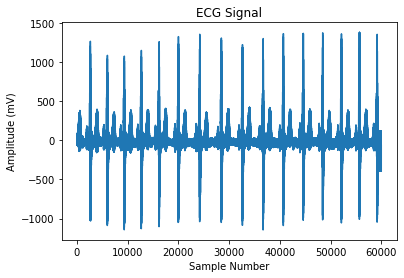

<Figure size 7200x7200 with 0 Axes>

In [50]:
import numpy as np
import matplotlib.pyplot as plt
ecg_data = np.fromfile('C:/major/records500/05000/05160_hr.dat', dtype=np.int16)
print(ecg_data)
plt.plot(ecg_data)
plt.title('ECG Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')
f = plt.figure()
f.set_figwidth(100)
f.set_figheight(100)
f.show()

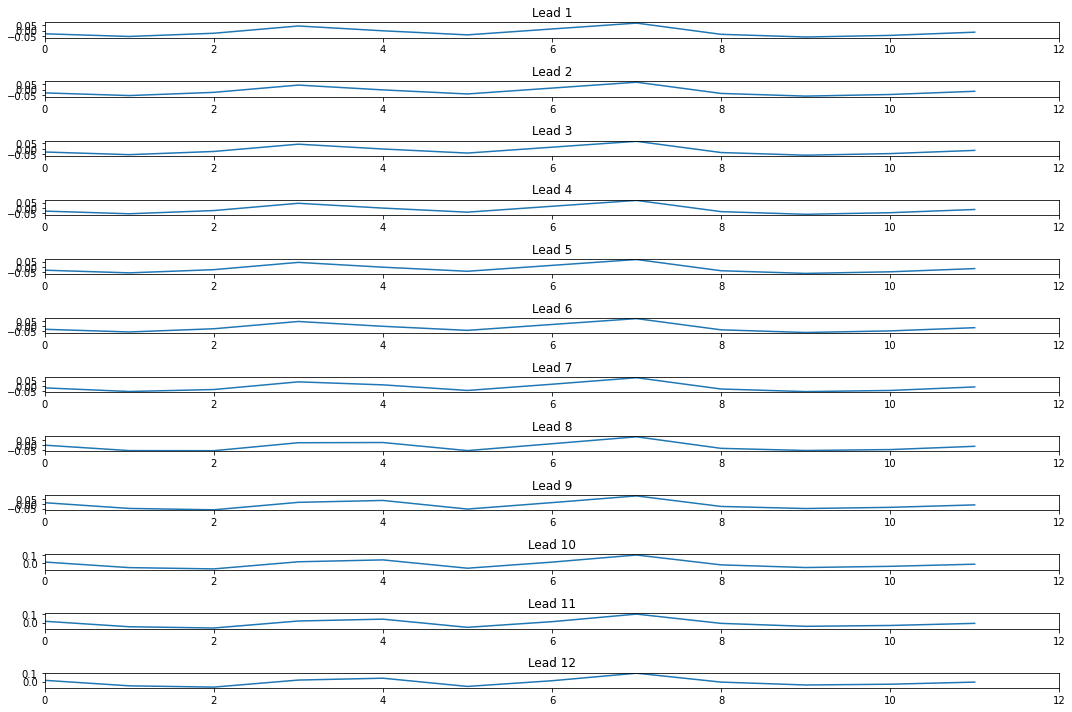

In [35]:
import wfdb
def plot_ecg():
    record = wfdb.rdrecord('C:/major/records500/05000/05160_hr')
    signal = record.p_signal
    fig, ax = plt.subplots(record.n_sig, 1, figsize=(15, 10))
    for i in range(record.n_sig):
        ax[i].plot(signal[i])
        ax[i].set_title(f'Lead {i + 1}')
        ax[i].set_xlim([0, len(signal[i])])
    plt.tight_layout()
    plt.show()
plot_ecg()

# Feature Extraction from ECG

In [86]:
from scipy import signal
import matplotlib.pyplot as plt
import neurokit2 as nk
import biosppy

In [162]:
def denoise_visual(ecg):
    Fs = 500
    N = ecg.shape[1]
    t = ((np.linspace(0, N-1, N))/(Fs))
    cover = t.shape[0]
    t = t.reshape(1, cover)  
    n=2 
    Fcutoff_low = 0.5 
    Wn_low = ((2*Fcutoff_low)/(Fs))
    b_low, a_low = signal.butter(n, Wn_low, 'low')
    xn_filtered_LF = signal.filtfilt(b_low, a_low, ecg)
    Fcutoff_high = 40 
    Wn_high = ((2*Fcutoff_high)/(Fs))
    b_high, a_high = signal.butter(n, Wn_high, 'high')
    xn_filtered_HF = signal.filtfilt(b_high, a_high, ecg)
    xn = (ecg-xn_filtered_HF-xn_filtered_LF)
    # Plot original ECG
    plt.plot(ecg[0][:1000], 'b', label='Original ECG')
    # Plot filtered ECG
    plt.plot(xn[0][:1000], 'r', label='Filtered ECG')
    plt.legend(loc='best')
    plt.xlabel('Sample number')
    plt.ylabel('ECG amplitude')
    plt.show()
    return xn

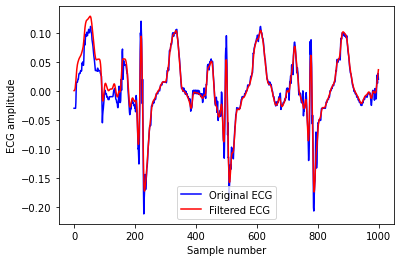

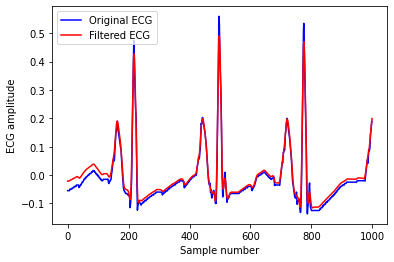

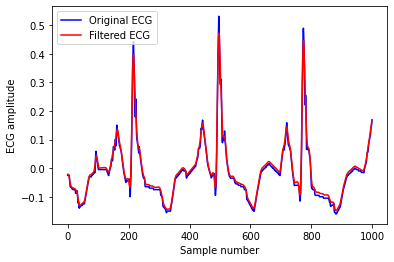

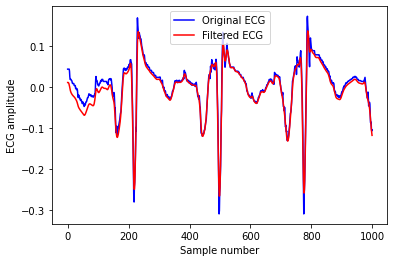

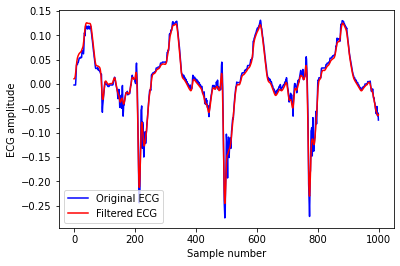

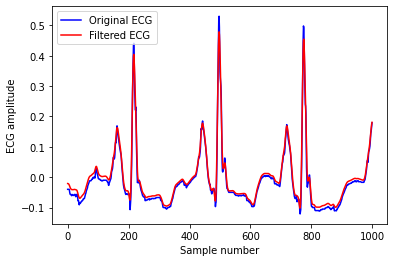

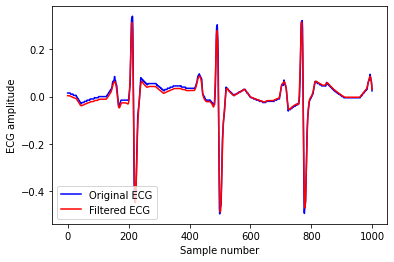

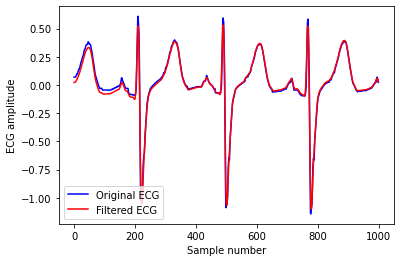

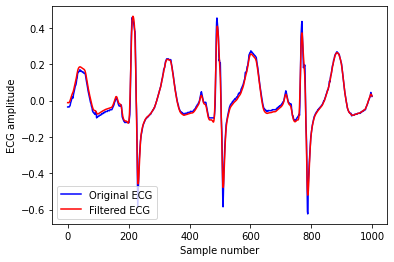

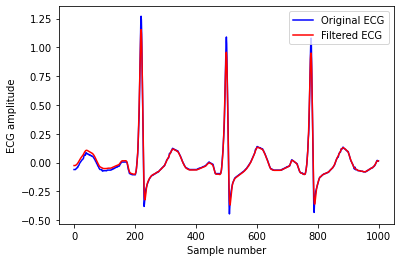

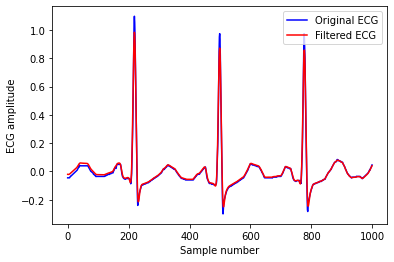

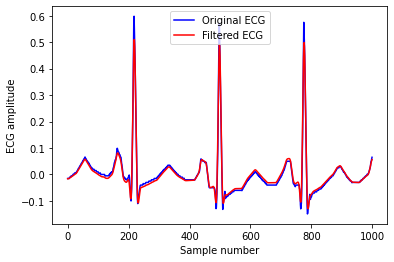

In [163]:
sig, meta_val = wfdb.rdsamp('C:/major/records500/05000/05160_hr')
value = sig.T
filterecg=[]
for ind in range(12):
    val_ind = value[ind]
    tmpp = val_ind.shape[0]
    val_ind = val_ind.reshape(1, tmpp)
    val_filtered =denoise_visual(val_ind)
    val_filtered = val_filtered.reshape(val_filtered.shape[1], )
    filterecg.append(val_filtered)


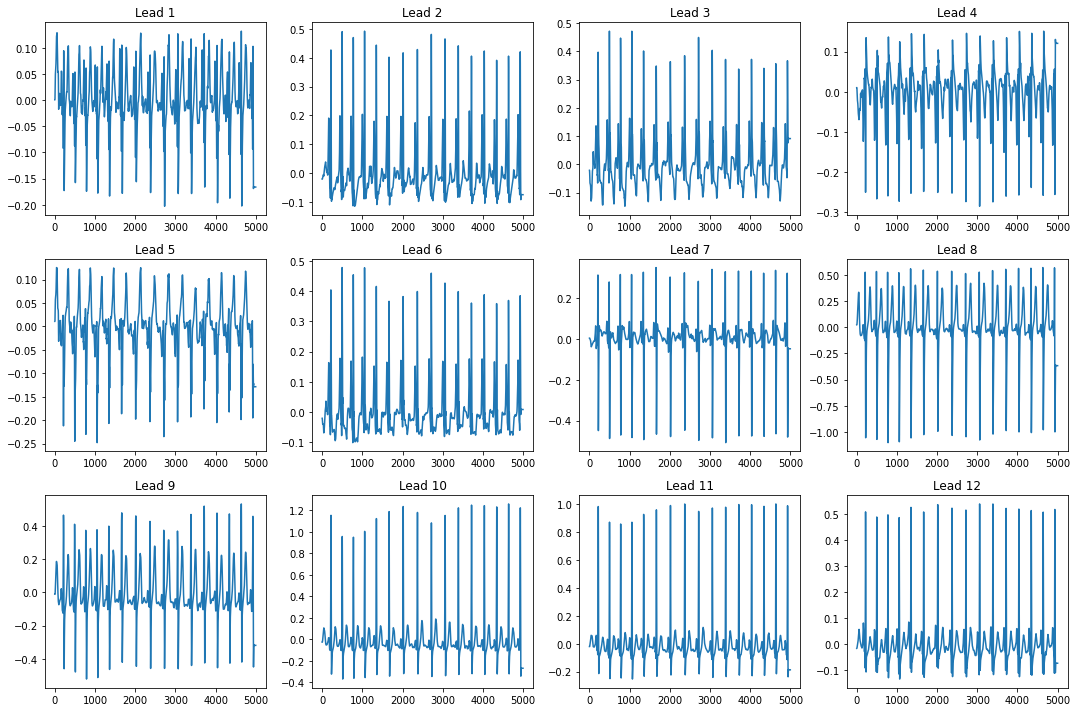

In [89]:

plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.plot(filterecg[i])
    plt.title('Lead ' + str(i+1))
plt.tight_layout()
plt.show()


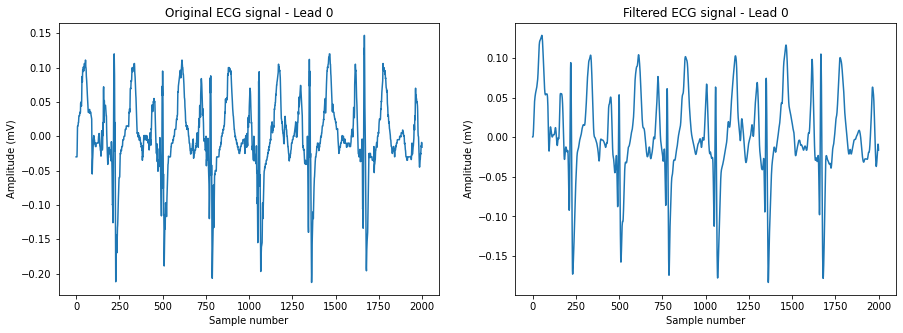

In [90]:

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(value[0][:2000])
plt.title('Original ECG signal - Lead 0')
plt.xlabel('Sample number')
plt.ylabel('Amplitude (mV)')
plt.subplot(1,2,2)
plt.plot(filterecg[0][:2000])
plt.title('Filtered ECG signal - Lead 0')
plt.xlabel('Sample number')
plt.ylabel('Amplitude (mV)')
plt.show()


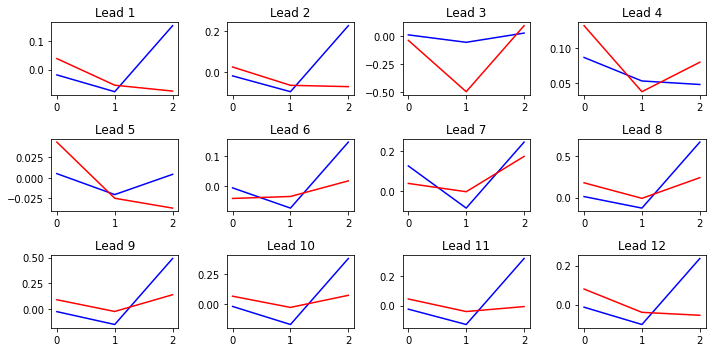

In [142]:
# normal_mat = np.array(normal_features).reshape(12, -1)
# mi_mat = np.array(mi_features).reshape(12, -1)
# # Visualize the normal ECG and MI ECG
# plt.figure(figsize=(10, 5))
# for i in range(12):
#     plt.subplot(3, 4, i+1)
#     plt.plot(normal_mat[i], 'b', label='Normal')
#     plt.plot(mi_mat[i], 'r', label='MI')
#     plt.title(f'Lead {i+1}')
# plt.tight_layout()
# plt.show()

In [164]:
def denoise_ecg(ecg):
    Fs = 500.
    N = ecg.shape[1]
    t = ((np.linspace(0, N-1, N))/(Fs))
    cover = t.shape[0]
    t = t.reshape(1, cover)  
    n=2 
    Fcutoff_low = 0.5 
    Wn_low = ((2*Fcutoff_low)/(Fs))
    b_low, a_low = signal.butter(n, Wn_low, 'low')
    xn_filtered_LF = signal.filtfilt(b_low, a_low, ecg)

    Fcutoff_high = 40 
    Wn_high = ((2*Fcutoff_high)/(Fs))
    b_high, a_high = signal.butter(n, Wn_high, 'high')
    xn_filtered_HF = signal.filtfilt(b_high, a_high, ecg)
    xn = (ecg-xn_filtered_HF-xn_filtered_LF)
    return xn

In [179]:
final_list_X = [] 
final_list_y = []
def read_data(feat_inp, targ_inp):
    path = r'C:\major'
    temp = feat_inp
    new_arr = np.reshape(temp, temp.shape[0])
    record_no = 0
    for f in new_arr:
        print(f,record_no)
        try:
            signal, meta_val = wfdb.rdsamp(path + '/' + f)
            s = signal.T
            temp_list = []
            flag1 = -1
            for i in range(12):
                v=s[i]
                tmp = v.shape[0]
                v = v.reshape(1, tmp)
                filtered = denoise_ecg(v)
                filtered = filtered.reshape(filtered.shape[1], )
                j= features(filtered)
                if(j == 'INCOMPLETE'):
                    temp_list = []
                    flag1 = 1
                    break
                temp_list.append(j)
            if(flag1==-1):
#                 print(temp_list)
#                 print( targ_inp[record_no])
                result_array(temp_list, targ_inp[record_no])

            record_no = record_no + 1
        except (ValueError,FileNotFoundError,OSError) as e:
            print("NAN Value")

In [180]:

def features(ecg_test):
    cleaned = nk.ecg_clean(ecg_test, sampling_rate=500)
    rdet, = biosppy.ecg.hamilton_segmenter(signal=cleaned, sampling_rate=500)
    rdet, = biosppy.ecg.correct_rpeaks(signal=cleaned, rpeaks=rdet, sampling_rate=500, tol=0.05)
    
    if rdet.size <= 4:
        return 'INCOMPLETE'
    
    rdet = np.delete(rdet, -1)
    rdet = np.delete(rdet, 0)
    rpeaks = {'ECG_R_Peaks': rdet}
    cleaned_base = nk.signal_detrend(cleaned, order=0)
    signals, waves = nk.ecg_delineate(cleaned_base, rpeaks, sampling_rate=500, method="dwt")
    rpeakss = rpeaks.copy()
    temppo = 4 - len(rpeakss['ECG_R_Peaks'])
    if temppo > 0:
        for i in range(temppo):
            rpeakss['ECG_R_Peaks'] = np.append(rpeakss['ECG_R_Peaks'], rpeakss['ECG_R_Peaks'][-1] + 1)

    signals1, waves1 = nk.ecg_delineate(cleaned_base, rpeakss, sampling_rate=500, method="peak")

    if temppo > 0:
        for j in range(temppo):
            waves1['ECG_Q_Peaks'] = waves1['ECG_Q_Peaks'][:-1]
            
    return cleaned_base, [waves['ECG_T_Peaks'], waves['ECG_R_Onsets'], waves['ECG_R_Offsets'], waves1['ECG_Q_Peaks']]


In [181]:
def result_array(ecg_data, target_value):
    min_len = 50
    for lead_data in ecg_data:
        for i in range(4):
            min_len = min(min_len, len(lead_data[1][i]))
    num_beats = min(16, min_len)

    for beat_index in range(num_beats):
        beat_features = []
        flag = -1
        
        for lead_index in range(12):
            
            if((np.isnan(ecg_data[lead_index][1][1][beat_index])) or 
               (np.isnan(ecg_data[lead_index][1][2][beat_index])) or 
               (np.isnan(ecg_data[lead_index][1][3][beat_index])) or 
               (np.isnan(ecg_data[lead_index][1][0][beat_index]))):
                
                beat_features = []
                flag = 1
                break
            
            r_onset = ecg_data[lead_index][0][int(ecg_data[lead_index][1][1][beat_index])]
            r_offset = ecg_data[lead_index][0][int(ecg_data[lead_index][1][2][beat_index])]
            q_peak = ecg_data[lead_index][0][int(ecg_data[lead_index][1][3][beat_index])]
            t_peak = ecg_data[lead_index][0][int(ecg_data[lead_index][1][0][beat_index])]

            first_feature = r_onset - r_offset
            second_feature = q_peak
            third_feature = t_peak

            beat_features.append(first_feature)
            beat_features.append(second_feature)
            beat_features.append(third_feature)

        if flag == -1:
            final_list_X.append(beat_features)
            final_list_y.append(target_value)

In [182]:
read_data(b1,b2)

records500/05000/05160_hr 0
records500/13000/13150_hr 1
records500/12000/12752_hr 2
records500/10000/10545_hr 3
records500/19000/19796_hr 4
records500/15000/15525_hr 5
records500/15000/15523_hr 6
records500/07000/07126_hr 7
records500/19000/19199_hr 8
records500/04000/04014_hr 9
records500/05000/05202_hr 10
records500/00000/00996_hr 11
records500/09000/09386_hr 12
records500/04000/04375_hr 13
records500/18000/18498_hr 14
records500/07000/07780_hr 15
records500/04000/04564_hr 16
records500/10000/10274_hr 17
records500/03000/03135_hr 18
records500/10000/10370_hr 19
records500/11000/11460_hr 20
records500/06000/06212_hr 21
records500/00000/00826_hr 22
records500/14000/14847_hr 23
records500/02000/02189_hr 24
records500/01000/01033_hr 25
records500/00000/00603_hr 26
records500/11000/11066_hr 27
records500/03000/03772_hr 28
records500/21000/21658_hr 29
records500/17000/17516_hr 30
records500/11000/11533_hr 31
records500/06000/06289_hr 32
records500/08000/08658_hr 33
records500/17000/17845_h

C:\Users\chint\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


records500/05000/05731_hr 210
records500/16000/16500_hr 211
records500/07000/07988_hr 212
records500/15000/15623_hr 213
records500/09000/09255_hr 214
records500/06000/06810_hr 215
records500/04000/04455_hr 216
records500/00000/00077_hr 217
records500/20000/20528_hr 218
records500/09000/09532_hr 219
records500/13000/13900_hr 220
records500/18000/18593_hr 221
records500/18000/18298_hr 222
records500/07000/07498_hr 223
records500/06000/06067_hr 224
records500/19000/19321_hr 225
records500/07000/07119_hr 226
records500/05000/05305_hr 227
records500/04000/04102_hr 228
records500/08000/08229_hr 229
records500/01000/01890_hr 230
records500/18000/18301_hr 231
records500/07000/07208_hr 232
records500/03000/03559_hr 233
records500/15000/15809_hr 234
records500/02000/02569_hr 235
records500/13000/13484_hr 236
records500/08000/08449_hr 237
records500/11000/11403_hr 238
records500/19000/19566_hr 239
records500/17000/17180_hr 240
records500/08000/08285_hr 241
records500/18000/18822_hr 242
records500

C:\Users\chint\anaconda3\lib\site-packages\neurokit2\signal\signal_period.py:70: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


NAN Value
records500/13000/13445_hr 416
records500/21000/21404_hr 417
records500/04000/04301_hr 418
records500/16000/16943_hr 419
records500/20000/20613_hr 420
records500/01000/01561_hr 421
records500/20000/20496_hr 422
records500/20000/20048_hr 423
records500/04000/04176_hr 424
records500/11000/11235_hr 425
records500/21000/21539_hr 426
records500/20000/20924_hr 427
records500/18000/18044_hr 428
records500/11000/11450_hr 429
records500/00000/00409_hr 430
records500/04000/04953_hr 431
records500/09000/09125_hr 432
records500/15000/15274_hr 433
records500/20000/20422_hr 434
records500/00000/00418_hr 435
records500/21000/21799_hr 436
records500/16000/16856_hr 437
records500/14000/14194_hr 438
records500/05000/05684_hr 439
records500/10000/10713_hr 440
records500/20000/20082_hr 441
records500/02000/02134_hr 442
records500/19000/19125_hr 443
records500/20000/20784_hr 444
records500/01000/01249_hr 445
records500/08000/08651_hr 446
records500/06000/06606_hr 447
records500/13000/13328_hr 448


C:\Users\chint\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


records500/06000/06088_hr 541
records500/01000/01248_hr 542
records500/00000/00391_hr 543
records500/08000/08751_hr 544
records500/12000/12713_hr 545
records500/10000/10047_hr 546
records500/03000/03336_hr 547
records500/15000/15228_hr 548
records500/20000/20712_hr 549
records500/12000/12495_hr 550
records500/03000/03868_hr 551
records500/06000/06767_hr 552
records500/19000/19709_hr 553
records500/06000/06532_hr 554
records500/07000/07824_hr 555
records500/17000/17135_hr 556
records500/08000/08527_hr 557
records500/18000/18023_hr 558
records500/17000/17939_hr 559
records500/15000/15852_hr 560
records500/15000/15324_hr 561
records500/06000/06618_hr 562
records500/00000/00175_hr 563
records500/14000/14333_hr 564
records500/06000/06853_hr 565
records500/01000/01415_hr 566
records500/19000/19149_hr 567
records500/12000/12271_hr 568
records500/16000/16226_hr 569
records500/08000/08729_hr 570
records500/03000/03403_hr 571
records500/07000/07953_hr 572
records500/12000/12954_hr 573
records500

C:\Users\chint\anaconda3\lib\site-packages\neurokit2\signal\signal_period.py:70: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


NAN Value
records500/19000/19938_hr 1489
records500/15000/15811_hr 1490
records500/00000/00482_hr 1491
records500/06000/06394_hr 1492
records500/12000/12867_hr 1493
records500/12000/12444_hr 1494
records500/17000/17769_hr 1495
records500/09000/09030_hr 1496
records500/04000/04002_hr 1497
records500/13000/13349_hr 1498
records500/10000/10457_hr 1499
records500/08000/08073_hr 1500
records500/00000/00510_hr 1501
records500/20000/20611_hr 1502
records500/00000/00234_hr 1503
records500/09000/09150_hr 1504
records500/17000/17397_hr 1505
records500/21000/21130_hr 1506
records500/11000/11194_hr 1507
records500/14000/14042_hr 1508
records500/13000/13495_hr 1509
records500/15000/15664_hr 1510
records500/21000/21709_hr 1511
records500/13000/13933_hr 1512
records500/04000/04946_hr 1513
records500/16000/16444_hr 1514
records500/15000/15604_hr 1515
records500/11000/11717_hr 1516
records500/01000/01059_hr 1517
records500/05000/05034_hr 1518
records500/02000/02605_hr 1519
records500/15000/15091_hr 152

C:\Users\chint\anaconda3\lib\site-packages\neurokit2\signal\signal_period.py:70: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


NAN Value
records500/05000/05593_hr 5090
records500/20000/20313_hr 5091
records500/17000/17884_hr 5092
records500/04000/04946_hr 5093
records500/02000/02450_hr 5094
records500/15000/15376_hr 5095
records500/21000/21521_hr 5096
records500/08000/08515_hr 5097
records500/18000/18018_hr 5098
records500/02000/02610_hr 5099
records500/18000/18734_hr 5100
records500/09000/09590_hr 5101
records500/17000/17419_hr 5102
records500/02000/02802_hr 5103
records500/16000/16559_hr 5104
records500/00000/00716_hr 5105
records500/10000/10437_hr 5106
records500/03000/03599_hr 5107
records500/14000/14252_hr 5108
records500/03000/03875_hr 5109
records500/17000/17575_hr 5110
records500/03000/03875_hr 5111
records500/19000/19210_hr 5112
records500/02000/02610_hr 5113
records500/04000/04990_hr 5114
records500/18000/18542_hr 5115
records500/13000/13951_hr 5116
records500/19000/19582_hr 5117
records500/19000/19074_hr 5118
records500/13000/13190_hr 5119
records500/13000/13337_hr 5120
records500/14000/14111_hr 512

C:\Users\chint\anaconda3\lib\site-packages\neurokit2\signal\signal_period.py:70: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


NAN Value
records500/12000/12426_hr 5464
records500/20000/20588_hr 5465
records500/02000/02749_hr 5466
records500/18000/18421_hr 5467
records500/08000/08229_hr 5468
records500/02000/02600_hr 5469
records500/12000/12388_hr 5470
records500/05000/05179_hr 5471
records500/12000/12308_hr 5472
records500/19000/19341_hr 5473
records500/16000/16402_hr 5474
records500/12000/12153_hr 5475
records500/04000/04617_hr 5476
records500/03000/03563_hr 5477
records500/03000/03567_hr 5478
records500/14000/14160_hr 5479
records500/12000/12994_hr 5480
records500/10000/10832_hr 5481
records500/21000/21716_hr 5482
records500/10000/10771_hr 5483
records500/19000/19360_hr 5484
records500/01000/01014_hr 5485
records500/12000/12223_hr 5486
records500/11000/11235_hr 5487
records500/06000/06242_hr 5488
records500/07000/07325_hr 5489
records500/09000/09482_hr 5490
records500/04000/04617_hr 5491
records500/18000/18018_hr 5492
records500/11000/11043_hr 5493
records500/19000/19488_hr 5494
records500/01000/01317_hr 549

In [185]:
len(final_list_X)

25970

In [186]:
len(final_list_y)

25970

In [187]:
Counter(final_list_y)

Counter({3: 2845,
         8: 2801,
         4: 2685,
         2: 2438,
         1: 2660,
         0: 2809,
         7: 2973,
         5: 2776,
         9: 1931,
         6: 2052})

<BarContainer object of 10 artists>

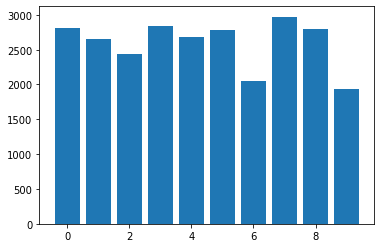

In [188]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH CLASS AFTER EXTRACTING BEATS FROM ECG:

my_dict3 = Counter(final_list_y)
keys3 = my_dict3.keys()
values3 = my_dict3.values()

plt.bar(keys3, values3)

In [189]:
X_train_array = np.array(final_list_X)

In [190]:
y_train_array = np.array(final_list_y)

In [191]:
print(X_train_array.shape)
print(y_train_array.shape)

(25970, 36)
(25970,)


In [195]:
def records_tt_split(Xin, yin):
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)    # 75%-25% split.
    skf.get_n_splits(Xin, yin)
    for train_index, test_index in skf.split(Xin, yin):
        X_train, X_test = Xin[train_index], Xin[test_index]
        y_train, y_test = yin[train_index], yin[test_index] 
    return (X_train, X_test, y_train, y_test)

In [192]:
X_train_array = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))  

In [193]:
print(X_train_array.shape)
print(y_train_array.shape)

(25970, 36, 1)
(25970,)


In [196]:
X_train, X_test, y_train, y_test = records_tt_split(X_train_array, y_train_array)

In [197]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19478, 36, 1)
(6492, 36, 1)
(19478,)
(6492,)


In [199]:
path_save= r'C:\Users\chint\OneDrive\Desktop\extracted'
np.save(path_save + '/' + 'Xtrain.npy', X_train)
np.save(path_save + '/' + 'Xtest.npy', X_test)
np.save(path_save + '/' + 'ytrain.npy', y_train)
np.save(path_save + '/' + 'ytest.npy', y_test)